In [21]:
import keras 
keras.__version__

'2.4.3'

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar 24 04:25 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


In [24]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
replace test/cats/cat.1501.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/cats/cat.1502.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [25]:
!ls -l

total 20
drwx------ 5 root root 4096 Mar 24 04:53 drive
drwxr-xr-x 1 root root 4096 Mar 18 13:36 sample_data
drwxr-xr-x 4 root root 4096 Mar 24 04:54 test
drwxr-xr-x 4 root root 4096 Mar 24 04:54 train
drwxr-xr-x 4 root root 4096 Mar 24 04:54 validation


In [26]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

In [27]:
from keras.applications import VGG16

conv_base = VGG16(weights= 'imagenet', include_top = False, # DNN부분은 가져오지 않겠다는(FALSE). CNN부분만 발췌
                  input_shape = (150, 150, 3))

In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [29]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale= 1./255)
batch_size=20

def extract_features(directory, sample_count):
  features = np.zeros(shape = (sample_count, 4, 4, 512))
  labels = np.zeros(shape = (sample_count))

  generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size, class_mode='binary')

  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : ( i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

In [30]:
%%time

train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 21.6 s, sys: 4.55 s, total: 26.1 s
Wall time: 25.9 s


In [31]:
train_features.shape, valid_features.shape, test_features.shape

((2000, 4, 4, 512), (1000, 4, 4, 512), (1000, 4, 4, 512))

In [33]:
train_features = np.reshape(train_features, (2000, 4*4*512))
valid_features = np.reshape(valid_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

train_features.shape, valid_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

In [36]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_shape = (4*4*512,))) # input_dim=4*4*512
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
%%time

Hist_dandc = model.fit(train_features, train_labels, epochs=100, batch_size=20, validation_data=(valid_features, valid_labels))

Epoch 1/100
100/100 [==============================] - 1s 6ms/step - loss: 0.6415 - accuracy: 0.7464 - val_loss: 0.2714 - val_accuracy: 0.8850
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2722 - accuracy: 0.8939 - val_loss: 0.3776 - val_accuracy: 0.8440
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2440 - accuracy: 0.8920 - val_loss: 0.3136 - val_accuracy: 0.8730
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1579 - accuracy: 0.9306 - val_loss: 0.2478 - val_accuracy: 0.8950
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1305 - accuracy: 0.9537 - val_loss: 0.4205 - val_accuracy: 0.8460
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1269 - accuracy: 0.9548 - val_loss: 0.3042 - val_accuracy: 0.8850
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.9686 - val_loss: 0.2594 - val_accuracy: 0.9050

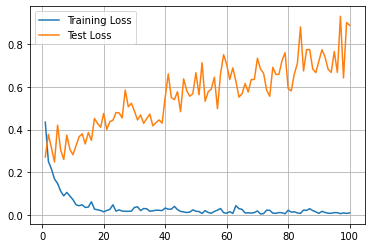

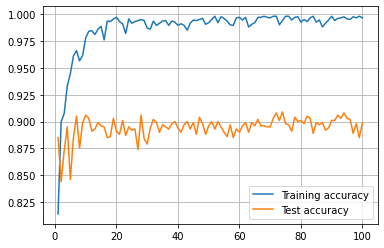

In [39]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss'])+1)


plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])
plt.legend(['Training Loss','Test Loss'])
plt.grid()
plt.show()



plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])
plt.legend(['Training accuracy','Test accuracy'])
plt.grid()
plt.show()

In [40]:
loss, accuracy = model.evaluate(test_features, test_labels)
loss, accuracy

32/32 [==============================] - 0s 3ms/step - loss: 0.9542 - accuracy: 0.8750


(0.9541575312614441, 0.875)

In [41]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
model.save('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_features_extraction.h5')

In [43]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 45456
-rw------- 1 root root 21346912 Mar 24 04:32 003_dogs_cats_augmentation.h5
-rw------- 1 root root 25199032 Mar 24 05:20 004_dogs_and_cats_features_extraction.h5


In [44]:
from keras.models import load_model
model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_features_extraction.h5')

loss, accuracy = model_google.evaluate(test_features, test_labels)
loss, accuracy

32/32 [==============================] - 0s 2ms/step - loss: 0.9542 - accuracy: 0.8750


(0.9541575312614441, 0.875)